In [1]:
#Getting coordinates imports

from geopy.geocoders import Nominatim #Transform Adresses to Coordinates (EPSG:4326)
from osgeo.osr import SpatialReference, CoordinateTransformation #Changing coordinatesystem (EPSG:4326 to EPSG:31370)

#Opening and clipping tif imports

import rasterio #Handling tif files
import rioxarray #Handling Rasters

#Showing CHM

from rasterio.plot import show
import numpy as np

import matplotlib.pyplot as plt
import os
import numpy as np
from osgeo import gdal
import subprocess


In [2]:
#Using Geopy to enter a random adress and convert into EPSG:4326 coordinates

#Input Adress by user
adress = input("Please enter your adress (f.e.: Beliestraat 137 2910 Essen) here: ")

#Getting the coordinates in EPSG:4326 system (standard)
geolocator = Nominatim(user_agent = "coordinate_finder")
location = geolocator.geocode(adress)

Please enter your adress (f.e.: Beliestraat 137 2910 Essen) here: Beliestraat 137 2910 Essen


In [3]:
#Changing coordinatesystem from 4326 to EPSG:31370

#Importing EPSG:4326 system
epsg4326 = SpatialReference() 
epsg4326.ImportFromEPSG(4326)

#Importing EPSG:4326 system
epsg31370 = SpatialReference()
epsg31370.ImportFromEPSG(31370)

#Make a transform function to change coordinates from a EPSG:4326 to a EPSG:31370 system
transform = CoordinateTransformation(epsg4326, epsg31370)

#Run transform function on Address coordinates 
(adress_lat, adress_long, _) = transform.TransformPoint(location.latitude, location.longitude)

In [5]:
#Checking in which DSM/DTM tif file these coordinates are located

////////////////
NOG IN TE VULLEN
////////////////

156488.49577211653 239213.01287099905


In [88]:
import requests
import json

#adress
streetname= input("Please enter a streetname: ")
house_number = input("Please enter a house number: ")
postal_code = input("Please enter a postal code: ")
town = input("Please enter a town: ")

r = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch",params={"straatnaam":streetname, "huisnummer":house_number, "postcode":postal_code, "gemeentenaam":town})
data = json.loads(r.content)

Please enter a streetname: Kloosterstraat
Please enter a house number: 70
Please enter a postal code: 2910
Please enter a town: Essen


In [89]:
#Automatisch objectId zoeken
ObjectId = data['adresMatches'][0]['adresseerbareObjecten'][0]['objectId']
print(ObjectId)

18658098


In [90]:
#gebouweenheid: objectId
r = requests.get("https://api.basisregisters.vlaanderen.be/v1/gebouweenheden/"+ObjectId)
data2 = json.loads(r.content)
print(data2)

{'identificator': {'id': 'https://data.vlaanderen.be/id/gebouweenheid/18658098', 'naamruimte': 'https://data.vlaanderen.be/id/gebouweenheid', 'objectId': '18658098', 'versieId': '2018-05-04T04:03:39+02:00'}, 'geometriePunt': {'point': {'coordinates': [156457.77, 239911.54], 'type': 'Point'}}, 'positieGeometrieMethode': 'afgeleidVanObject', 'gebouweenheidStatus': 'gerealiseerd', 'functie': 'nietGekend', 'gebouw': {'objectId': '18657458', 'detail': 'https://api.basisregisters.vlaanderen.be/v1/gebouwen/18657458'}, 'adressen': [{'objectId': '714195', 'detail': 'https://api.basisregisters.vlaanderen.be/v1/adressen/714195'}]}


In [91]:
#Automatisch objectId zoeken
ObjectId2 = data2['gebouw']['objectId']
print(ObjectId2)

18657458


In [92]:
#Polygon coordinates

r = requests.get("https://api.basisregisters.vlaanderen.be/v1/gebouwen/"+ObjectId2)
info = json.loads(r.content)
polygon_coor = info['geometriePolygoon']['polygon']['coordinates']
print(polygon_coor)

[[[156443.9180317074, 239908.95850443095], [156440.7045917064, 239930.40676044673], [156443.53851170838, 239930.8314004466], [156442.36577570438, 239938.6581524536], [156430.73774369806, 239936.91594445333], [156429.25441569835, 239936.69367245212], [156419.90830369294, 239935.29341645166], [156427.4969116971, 239884.64407241717], [156439.47630370408, 239886.45719241723], [156438.66043170542, 239891.84804042056], [156451.21223971248, 239893.73719242215], [156451.24321570992, 239893.5623444207], [156487.4009117335, 239898.99389642477], [156487.18459174037, 239900.51914442703], [156498.04257574677, 239902.09700042754], [156497.87233574688, 239903.22116042674], [156505.2320797518, 239904.33533642814], [156504.63028775156, 239908.31095243245], [156497.27054374665, 239907.19684043154], [156496.93607974052, 239909.40592843294], [156504.38350374997, 239910.53328843415], [156503.77601575106, 239914.54576843604], [156496.3287197426, 239913.41828043386], [156495.98439974338, 239915.6924564354], 

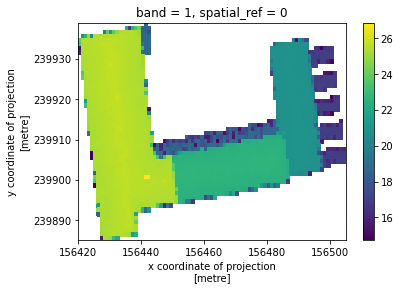

In [93]:
#Clipping of DSM tif

#Opening the DSM tif, read the mask and set values to NaN

DSM = rioxarray.open_rasterio("DHMVIIDSMRAS1m_k01.tif",
                                   masked=True)



#Making a polygon based on the boundaries around the Adress coordinates

clip_boundaries = [ {'type': 'Polygon',
                'coordinates': polygon_coor}]

#Actual clipping of the polygon from the DSM tif
   
clipped_DSM = DSM.rio.clip(clip_boundaries)

#Plotting the clipped DSM tif

clipped_DSM.plot()

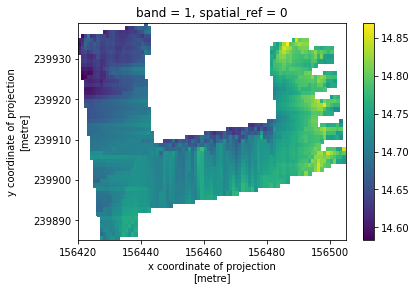

In [94]:
#Clipping of DTM tif

#Opening the DTM tif, read the mask and set values to NaN

DTM = rioxarray.open_rasterio("DHMVIIDTMRAS1m_k01.tif",
                                   masked=True)

#Choosing Boundary of the clip (in EPSG:31370 coordinates)
#on each side of the Adress coordinates

#Actual clipping of the polygon from the DTM tif
   
clipped_DTM = DTM.rio.clip(clip_boundaries)

#Plotting the clipped DTM tif

clipped_DTM.plot()



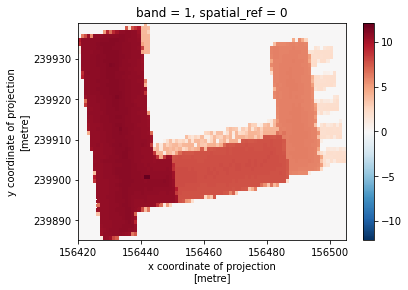

In [95]:
#Calculating and plotting the CHM

clipped_CHM = clipped_DSM - clipped_DTM 
clipped_CHM.compute()
clipped_CHM = clipped_CHM.fillna(0)
clipped_CHM.plot()

In [97]:
#3D plotting with ploty Surface

import plotly.graph_objects as go

import pandas as pd

# Read data from a csv

fig = go.Figure(data=[go.Surface(z = clipped_CHM[0])])

fig.update_layout(title='3D plot house')

fig.show()


In [10]:
import plotly.graph_objects as go

import pandas as pd

# Read data from a csv

fig = go.Figure(data=[go.Mesh3d(z = clipped_CHM[0])])

fig.update_layout(title='3D plot house')

fig.show()

#Using mesh instead of surface

In [77]:
print(clipped_CHM.shape, type(clipped_CHM))

dask.is_dask_collection(clipped_CHM)

(1, 11, 15) <class 'xarray.core.dataarray.DataArray'>


NameError: name 'dask' is not defined

In [16]:
print(clipped_CHM.fillna(0))

<xarray.DataArray (band: 1, y: 11, x: 15)>
array([[[0.        , 0.        , 5.88999939, 5.5199995 , 5.17000008,
         4.73999977, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 7.02000046, 6.71999931, 6.35999966,
         6.06052876, 5.75971222, 6.50944901, 6.32567692, 5.00546741,
         0.        , 4.25      , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 8.15999985, 7.82999992, 7.55618   ,
         7.24008751, 7.19800568, 7.11876011, 6.92471695, 6.80630207,
         6.61160374, 5.76028061, 5.03999996, 4.82000065, 4.49999905],
        [0.        , 0.        , 9.18493176, 8.95114613, 8.69470882,
         8.37226486, 8.06844616, 7.78833008, 7.53829384, 7.41248608,
         7.23108578, 6.58494282, 6.28261852, 5.96000004, 5.6400013 ],
        [0.        , 7.92323875, 8.17732811, 8.385252  , 8.70487022,
         9.00540638, 9.17055416, 8.81876373, 8.58889771,

In [13]:
clipped_CHM.shape

(1, 11, 15)

In [36]:
values = clipped_CHM.values
print(values)

[[[       nan        nan 5.88999939 5.5199995  5.17000008 4.73999977
          nan        nan        nan        nan        nan        nan
          nan        nan        nan]
  [       nan        nan 7.02000046 6.71999931 6.35999966 6.06052876
   5.75971222 6.50944901 6.32567692 5.00546741        nan 4.25
          nan        nan        nan]
  [       nan        nan 8.15999985 7.82999992 7.55618    7.24008751
   7.19800568 7.11876011 6.92471695 6.80630207 6.61160374 5.76028061
   5.03999996 4.82000065 4.49999905]
  [       nan        nan 9.18493176 8.95114613 8.69470882 8.37226486
   8.06844616 7.78833008 7.53829384 7.41248608 7.23108578 6.58494282
   6.28261852 5.96000004 5.6400013 ]
  [       nan 7.92323875 8.17732811 8.385252   8.70487022 9.00540638
   9.17055416 8.81876373 8.58889771 8.21715736 7.93863392 7.63594246
   7.34276772 7.05999947 6.81000042]
  [       nan 6.82999992 7.09741497 7.28861904 7.60927582 7.88300705
   8.19750214 8.44269371 8.71904564 9.05160046 9.44678974 8.75

In [37]:
values = values.reshape(-1)
print(values)

[       nan        nan 5.88999939 5.5199995  5.17000008 4.73999977
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 7.02000046
 6.71999931 6.35999966 6.06052876 5.75971222 6.50944901 6.32567692
 5.00546741        nan 4.25              nan        nan        nan
        nan        nan 8.15999985 7.82999992 7.55618    7.24008751
 7.19800568 7.11876011 6.92471695 6.80630207 6.61160374 5.76028061
 5.03999996 4.82000065 4.49999905        nan        nan 9.18493176
 8.95114613 8.69470882 8.37226486 8.06844616 7.78833008 7.53829384
 7.41248608 7.23108578 6.58494282 6.28261852 5.96000004 5.6400013
        nan 7.92323875 8.17732811 8.385252   8.70487022 9.00540638
 9.17055416 8.81876373 8.58889771 8.21715736 7.93863392 7.63594246
 7.34276772 7.05999947 6.81000042        nan 6.82999992 7.09741497
 7.28861904 7.60927582 7.88300705 8.19750214 8.44269371 8.71904564
 9.05160046 9.44678974 8.75053406 8.50563622 8.20179367 7.41000

In [54]:
x = list(np.linspace(0,clipped_CHM.shape[1],clipped_CHM.shape[1]+1))
for i in range(0,clipped_CHM.shape[2]):
    x += x
print(x)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 0.0, 1.

In [ ]:
y = []
for i in range(0,clipped_CHM.shape[1]):
    x += x
print(x)

In [47]:
import plotly.graph_objects as go

y = np.linspace(0,clipped_CHM.shape[2],clipped_CHM.shape[2]+1)
z = values

fig = go.Figure(data=[go.Mesh3d(x = x,
                                y = y,
                                z = z,color='red', opacity=0.50)])
fig.show()

In [46]:
x = clipped_CHM.shape[2] * x
print(x)

[  0.  15.  30.  45.  60.  75.  90. 105. 120. 135. 150. 165.]


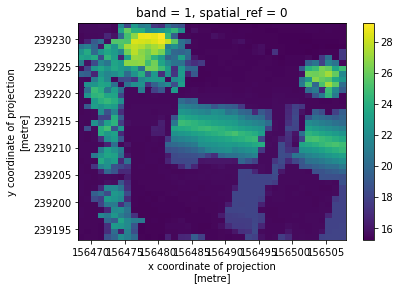

In [4]:
#Clipping of DSM tif

#Opening the DSM tif, read the mask and set values to NaN

DSM = rioxarray.open_rasterio("DHMVIIDSMRAS1m_k01.tif",
                                   masked=True)

#Choosing Boundary of the clip (in EPSG:31370 coordinates)
#on each side of the Adress coordinates

boundary = 20

#Left upper corner
xmin_ymax = [(adress_lat-boundary),(adress_long+boundary)]

#Right upper corner
xmax_ymax = [(adress_lat+boundary),(adress_long+boundary)]

#Left lower corner
xmax_ymin = [(adress_lat+boundary),(adress_long-boundary)]

#Right lower corner
xmin_ymin = [(adress_lat-boundary),(adress_long-boundary)]

#Making a polygon based on the boundaries around the Adress coordinates

clip_boundaries = [ {'type': 'Polygon',
                'coordinates': [[xmin_ymax,
                                 xmax_ymax,
                                 xmax_ymin,
                                 xmin_ymin ]]}]

#Actual clipping of the polygon from the DSM tif
   
clipped_DSM = DSM.rio.clip(clip_boundaries)

#Plotting the clipped DSM tif

clipped_DSM.plot()

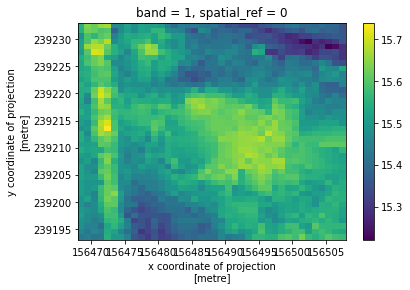

In [5]:
#Clipping of DTM tif

#Opening the DTM tif, read the mask and set values to NaN

DTM = rioxarray.open_rasterio("DHMVIIDTMRAS1m_k01.tif",
                                   masked=True)

#Choosing Boundary of the clip (in EPSG:31370 coordinates)
#on each side of the Adress coordinates

boundary = 20

#Left upper corner
xmin_ymax = [(adress_lat-boundary),(adress_long+boundary)]

#Right upper corner
xmax_ymax = [(adress_lat+boundary),(adress_long+boundary)]

#Left lower corner
xmax_ymin = [(adress_lat+boundary),(adress_long-boundary)]

#Right lower corner
xmin_ymin = [(adress_lat-boundary),(adress_long-boundary)]

#Making a polygon based on the boundaries around the Adress coordinates

clip_boundaries = [ {'type': 'Polygon',
                'coordinates': [[xmin_ymax,
                                 xmax_ymax,
                                 xmax_ymin,
                                 xmin_ymin ]]}]

#Actual clipping of the polygon from the DTM tif
   
clipped_DTM = DTM.rio.clip(clip_boundaries)

#Plotting the clipped DTM tif

clipped_DTM.plot()

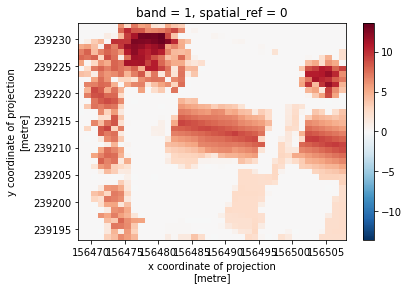

In [7]:
print(clipped_CHM)

<xarray.DataArray (band: 1, y: 40, x: 40)>
array([[[0.05000019, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.01000023, 0.        , 0.02000046, ..., 0.        ,
         0.        , 0.        ],
        [0.01000023, 0.        , 0.03999996, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 2.41999912,
         2.43999958, 2.46000004],
        [0.        , 0.        , 0.        , ..., 2.42999935,
         2.4800005 , 2.4800005 ],
        [0.        , 0.        , 0.02999973, ..., 2.42000008,
         2.44000053, 2.45000076]]])
Coordinates:
  * y            (y) float64 2.392e+05 2.392e+05 ... 2.392e+05 2.392e+05
  * x            (x) float64 1.565e+05 1.565e+05 ... 1.565e+05 1.565e+05
  * band         (band) int32 1
    spatial_ref  int32 0


In [8]:
print(clipped_CHM[0,0,0])

<xarray.DataArray ()>
array(0.05000019)
Coordinates:
    y            float64 2.392e+05
    x            float64 1.565e+05
    band         int32 1
    spatial_ref  int32 0


In [9]:
values = clipped_CHM.values
print(values)

[[[0.05000019 0.         0.         ... 0.         0.         0.        ]
  [0.01000023 0.         0.02000046 ... 0.         0.         0.        ]
  [0.01000023 0.         0.03999996 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 2.41999912 2.43999958 2.46000004]
  [0.         0.         0.         ... 2.42999935 2.4800005  2.4800005 ]
  [0.         0.         0.02999973 ... 2.42000008 2.44000053 2.45000076]]]


In [10]:
clipped_CHM.shape

(1, 40, 40)

In [13]:
#Dataframe gemaakt met coordinates punten

import csv

for i in range(0,values.shape[0]):
    for j in range(0,values.shape[1]):
        for k in range(0,values.shape[2]):
            if i == 0 and j == 0 and k == 0:
                with open('chmdata.csv', 'w', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow(['x', 'y', 'z'])
                    writer.writerow([i, j, values[i,j,k]])
            else:
                with open('chmdata.csv', 'a', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow([i, j, values[i,j,k]])

In [11]:
import pandas as pd

chmchm = pd.read_csv("chmdata.csv")
display(chmchm)

chm = np.linspace((adress_lat-boundary),2* boundary)
                                                 (adress_lat+boundary)),
                                 y = np.linspace((adress_long-boundary)

#1600 rows  = 1 * 40 * 40

,x,y,z
0,0,0,0.050000
1,0,0,0.000000
2,0,0,0.000000
3,0,0,0.000000
4,0,0,0.000000
...,...,...,...
1595,0,39,0.000000
1596,0,39,2.430000
1597,0,39,2.420000
1598,0,39,2.440001


In [36]:
x_list = []
for i in range(0,40):
    x_list.append(i)
x_list *= (boundary*2)
print(x_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2

In [37]:
import plotly.graph_objects as go

import pandas as pd

# Read data from a csv
z_data = pd.read_csv('chmdata.csv')

fig = go.Figure(data=[go.Surface(x = x_list,
                                 y = z_data['y'].values,
                                 z=z_data['z'].values)])

fig.update_layout(title='3D plot house')

fig.show()

#Using mesh instead of surface

In [38]:
import plotly.graph_objects as go


fig = go.Figure(data=[go.Mesh3d(x = x_list,
                                 y = chmchm['y'].values,
                                 z= chmchm['z'].values,color='red', opacity=0.50)])
fig.show()

In [19]:
import plotly.express as px

fig = px.scatter_3d(x=np.linspace((adress_lat-boundary),
                                                 (adress_lat+boundary)),
                    y = np.linspace((adress_long-boundary),
                                                 (adress_long+boundary)),
                                 z=chmchm['z'].values)
fig.show()

ValueError: All arguments should have the same length. The length of argument `z` is 1600, whereas the length of  previously-processed arguments ['x', 'y'] is 50